# <center> Programming Assignment 3 </center>
## <center> SMDP \& Intra-Option Q-Learning </center>

### Preliminaries

Installing a legacy version of gym to ensure compatibility with the code provided in tutorial 7.

In [1]:
! pip install gym==0.15.3

Importing necessary libraries:

In [2]:
import gym

import io
import sys
import glob
import random

import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import HTML

Initializing and exploring the environment:

In [3]:
# Initializing the Taxi-v3 environment
env = gym.make("Taxi-v3")
env.reset()

# State space
print("State space:", env.observation_space)

# Action space
print("Action space:", env.action_space)


State space: Discrete(500)
Action space: Discrete(6)


We see that the 500 possible states and the 6 possible actions are encoded by integers. 

From the documentation we find the following mapping for actions:

- 0: move south

- 1: move north

- 2: move east

- 3: move west

- 4: pickup passenger

- 5: drop off passenger

We use the decode method to decode the state from the integer value. We illustrate the process below:

In [4]:
taxi_row, taxi_col, psng_idx, dest_idx = list(env.decode(env.s))
print("(Taxi row, Taxi col):", (taxi_row, taxi_col))
print("Passenger location:", psng_idx)
print("Passenger destination:", dest_idx)

(Taxi row, Taxi col): (1, 4)
Passenger location: 2
Passenger destination: 1


taxi_row gives the row in which the taxi is currently located.

taxi_col gives the column in which the taxi is currently located.

psng_idx corresponds to the locations of the passenger as per the following table:
- 0: R(ed)

- 1: G(reen)

- 2: Y(ellow)

- 3: B(lue)

- 4: in taxi

dest_idx corresponds to the destinations of the passenger as per the following table:
- 0: R(ed)

- 1: G(reen)

- 2: Y(ellow)

- 3: B(lue)


        

To verify if the decoding works as expected, we render the environment and decode the current state:

In [5]:
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



For the rest of the notebook, taxi location (x, y) corresponds to the taxi being at row x and column y.

Next we observe the changes after taking a step randomly:

In [6]:
rnd_action = np.random.choice(np.arange(6))
print("Action taken:", rnd_action)

next_state, reward, is_terminal, t_prob = env.step(rnd_action)
print("Next state:", next_state)
print("Reward:", reward)
print("Is the new state terminal?", is_terminal)
print("Probability of transition:", t_prob)

env.render()

Action taken: 2
Next state: 189
Reward: -1
Is the new state terminal? False
Probability of transition: {'prob': 1.0}
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)


We also note that the reward structure is as follows:
- -1 per step unless other reward is triggered.

- +20 delivering passenger.

- -10 executing “pickup” and “drop-off” actions illegally.

### Defining options

We start by defining the options given in the problem statement. The problem statement asks us to define 4 options; one each for moving the taxi to one of the four designated locations (R, G, B, Y), executable
when the taxi is not already there.

For defining an option we require three components: a policy, a termination conidition and an initiation set. A description of these three for our case:

- Policy: The objective of the option is to move the taxi to a designated location. Since we are penalized with a -1 reward for every timestep, it makes sense to define the option such that it takes the least amount of time to reach the required location. We will keep this in consideration while designing policies for each option.

- Termination condition: In our case, this is rather straightforward as all the options terminate deterministically only on reaching the required location.

- Initiation set: The initiation set consists of all states apart from the target location. Therefore we use an if condition on the current state to check if the current state is a valid location to perform the option.

#### Move to R

We first define the option to move to R. Termination condition is straightforward. What is left is to define the policy. We use the following ideas to define the policy (for the shortest path):
- Note that wherever possible, it is optimal to move left (west). 
- Once you reach column 0, it is optimal to move up (north).
- If you are at (0, 2) or (1, 2), it is optimal to move down (south).
- If you are at (3, 1), (3, 3), (4, 1) or (4, 3), it is optimal to move up.

In [7]:
def moveToR(state, env):

  # Decode the state
  row, col, _, _ = list(env.decode(state))

  # Default values for action and termination condition
  opt_done = False
  opt_action = 0

  # Target reached
  if (row == 0 and col == 0):
    opt_done = True
    return opt_done, opt_action
  
  # Move up if in column 0
  if (col == 0):
    opt_action = 1
    return opt_done, opt_action

  # Move down if at (0, 2)
  if ((row == 0 and col == 2) or (row == 1 and col == 2)):
    opt_action = 0
    return opt_done, opt_action
  
  # Move up if at (3, 1), (3, 3), (4, 1) or (4, 3) 
  if ((row == 3 and col == 1) or (row == 3 and col == 3) or (row == 4 and col == 1) or (row == 4 and col == 3)):
    opt_action = 1
    return opt_done, opt_action

  # Otherwise move left
  opt_action = 3
  return opt_done, opt_action

In [8]:
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [9]:
a, b = moveToR(env.s, env)
env.step(b)
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)


#### Move to Y

This case is identical to the case of R except for the fact that you have to change termination condition and move down in column 0 instead of up.

In [10]:
def moveToY(state, env):

  # Decode the state
  row, col, _, _ = list(env.decode(state))

  # Default values for action and termination condition
  opt_done = False
  opt_action = 0

  # Target reached
  if (row == 4 and col == 0):
    opt_done = True
    return opt_done, opt_action
  
  # Move down if in column 0
  if (col == 0):
    opt_action = 0
    return opt_done, opt_action

  # Move down if at (0, 2) or (1, 2)
  if ((row == 0 and col == 2) or (row == 1 and col == 2)):
    opt_action = 0
    return opt_done, opt_action
  
  # Move up if at (3, 1), (3, 3), (4, 1) or (4, 3) 
  if ((row == 3 and col == 1) or (row == 3 and col == 3) or (row == 4 and col == 1) or (row == 4 and col == 3)):
    opt_action = 1
    return opt_done, opt_action

  # Otherwise move left
  opt_action = 3
  return opt_done, opt_action

In [11]:
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [12]:
a, b = moveToY(env.s, env)
env.step(b)
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)


#### Move to G

We use the following conditions:
- Once you reach column 4, it is optimal to move up (north).
- If you are at (0, 1) or (1, 1), it is optimal to move down (south).
- If you are at (3, 0), (3, 2), (4, 0) or (4, 2), it is optimal to move up.
- In all other cases, it is optimal to move right (east).

In [13]:
def moveToG(state, env):

  # Decode the state
  row, col, _, _ = list(env.decode(state))

  # Default values for action and termination condition
  opt_done = False
  opt_action = 0

  # Target reached
  if (row == 0 and col == 4):
    opt_done = True
    return opt_done, opt_action
  
  # Move up if in column 4
  if (col == 4):
    opt_action = 1
    return opt_done, opt_action

  # Move down if at (0, 1) or (1, 1)
  if ((row == 0 and col == 1) or (row == 1 and col == 1)):
    opt_action = 0
    return opt_done, opt_action
  
  # Move up if at (3, 0), (3, 2), (4, 0) or (4, 2) 
  if ((row == 3 and col == 0) or (row == 3 and col == 2) or (row == 4 and col == 0) or (row == 4 and col == 2)):
    opt_action = 1
    return opt_done, opt_action

  # Otherwise move right
  opt_action = 2
  return opt_done, opt_action

In [14]:
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [15]:
a, b = moveToG(env.s, env)
env.step(b)
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)


#### Move to B

We use the following conditions:
- Once you reach column 3 or column 4, it is optimal to move down (south).
- If you are at (0, 1) or (1, 1), it is optimal to move down (south).
- If you are at (3, 0), (3, 2), (4, 0) or (4, 2), it is optimal to move up.
- If you are at (4, 4), it is optimal to move left (west).
- In all other cases, it is optimal to move right (east).

In [16]:
def moveToB(state, env):

  # Decode the state
  row, col, _, _ = list(env.decode(state))

  # Default values for action and termination condition
  opt_done = False
  opt_action = 0

  # Target reached
  if (row == 4 and col == 3):
    opt_done = True
    return opt_done, opt_action

  # Move left if at (4, 4)
  if ((row == 4) and (col == 4)):
    opt_action = 3
    return opt_done, opt_action
  
  # Move down if in column 3 or 4
  if ((col == 3) or (col == 4)):
    opt_action = 0
    return opt_done, opt_action

  # Move down if at (0, 1) or (1, 1)
  if ((row == 0 and col == 1) or (row == 1 and col == 1)):
    opt_action = 0
    return opt_done, opt_action
  
  # Move up if at (3, 0), (3, 2), (4, 0) or (4, 2) 
  if ((row == 3 and col == 0) or (row == 3 and col == 2) or (row == 4 and col == 0) or (row == 4 and col == 2)):
    opt_action = 1
    return opt_done, opt_action


  # Otherwise move right
  opt_action = 2
  return opt_done, opt_action

In [17]:
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [18]:
a, b = moveToB(env.s, env)
env.step(b)
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)


In [19]:
a, b = moveToB(env.s, env)
print(a)

False


We assign an integer value to each option as follows:
- 6 : Move to R
- 7 : Move to Y
- 8 : Move to G
- 9 : Move to B

Therefore, including both primitive actions and options, we have a total of 10 possible actions.

### Initializations and helper functions

We define the exploration policy ($\epsilon$-greedy), Q-tables and frequency count tables.

We also define a list of the functions for performing options for ease of use:

In [20]:
opt_fns = [moveToR, moveToY, moveToG, moveToB]

Note that depending on whether the state is in the initiation set of an option or not, that option may or may not be available for execution. It is therefore necessary to perform $\epsilon$-greedy on the available set of actions. We provide the available set of actions as an argument to the $\epsilon$-greedy function. A separate function decides which all actions should be included in this set.

In [21]:
# Epsilon-greedy action selection function
def egreedy_policy(q_values, state, available_actions, epsilon):

  state_q_vals = q_values[state, np.array(available_actions)]
  
  if ( (np.random.rand() < epsilon) or (not state_q_vals.any()) ): 
        return np.random.choice(available_actions)

  else:
        return available_actions[np.argmax(state_q_vals)]

Next, we define a helper function which takes in the current state and outputs the available set of options that can be executed.

In [22]:
def gen_avl_options(state, env):

    row, col, _, _ = list(env.decode(state))

    avl_actions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    if (row == 0 and col == 0):
        avl_actions.pop(6)
        return avl_actions

    if (row == 4 and col == 0):
        avl_actions.pop(7)
        return avl_actions

    if (row == 0 and col == 4):
        avl_actions.pop(8)
        return avl_actions

    if (row == 4 and col == 3):
        avl_actions.pop(9)
        return avl_actions

    return avl_actions

## SMDP Q-Learning

In [23]:
class SMDP:
    """
    Intra_option_stuff
    """
    def __init__(self, gamma = 0.9, alpha = 0.1, epsilon = 0.1, opt_fns = opt_fns, gen_avl_options = gen_avl_options):
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.exp_name = 'a' + str(int(self.alpha*1000)) + '_e' + str(int(self.epsilon*1000)) + '_g' + str(int(self.gamma*100))
        self.q_values = np.zeros((500, 10))
        self.update_freq = np.zeros((500, 10))
        self.gen_avl_options = gen_avl_options
        self.opt_fns = opt_fns
        
        self.env = gym.make("Taxi-v3")
        
    def trainer(self, n_episodes = 3000, verbose = True):
        
        self.n_episodes = n_episodes
        self.eps_rewards = np.zeros(n_episodes)
        self.verbose = verbose
        
        # training over 3000 episodes
        for eps in (tqdm(range(n_episodes)) if verbose else range(n_episodes)):


            state = self.env.reset()   
            done = False
            eps_rew = 0

            # Loop till environment is solved
            while not done:

                # Get the available actions
                available_actions = self.gen_avl_options(state, self.env)

                # Epsilon-greedy action selection
                action = egreedy_policy(self.q_values, state, available_actions, self.epsilon)

                # Primitive actions
                if action < 6:

                    # Regular Q-Learning update
                    next_state, reward, done, dummy = self.env.step(action)
                    self.q_values[state, action] +=  self.alpha*(reward + self.gamma*np.max(self.q_values[next_state, :])
                                                                 - self.q_values[state, action])
                    self.update_freq[state, action] += 1
                    state = next_state
                    eps_rew += reward
  
                # Away option
                if action >= 6: 

                    # Initialize reward bar, start_state and optdone
                    reward_bar = 0             
                    opt_done = False
                    start_state = state
                    time_steps = 0
                    opt_fn = self.opt_fns[action-6]
     
                    # while the option hasnt terminated
                    while (opt_done == False):

                        # Apply the option
                        opt_done, opt_action = opt_fn(state, self.env)

                        # If option is done, update and terminate
                        # We multiply with gamma^time_steps to allow for correct scaling
                        if opt_done:
                            self.q_values[start_state, action] += self.alpha * (reward_bar + 
                                (self.gamma**time_steps) * np.max(self.q_values[state, :]) - self.q_values[start_state, action])
                            self.update_freq[start_state, action] += 1
                            break

                        next_state, reward, done, _ = self.env.step(opt_action)
                        time_steps += 1      
                        reward_bar += (self.gamma**(time_steps - 1))*reward      
                        eps_rew += reward
                        state = next_state
                        
            
            # find total reward of episode
            self.eps_rewards[eps] = eps_rew
        return self.eps_rewards, self.q_values, self.update_freq
            
    def plot_reward_curve(self, save = False):
        sns.set_style("darkgrid")
        avg100_reward = np.array([np.mean(self.eps_rewards[max(0,i-100):i]) for i in range(1,len(self.eps_rewards)+1)])

        plt.xlabel('Episode')
        plt.ylabel('Total Episode Reward')
        plt.title('Rewards vs Episodes: Avg Reward: %.3f'%np.mean(self.eps_rewards))
        plt.plot(np.arange(self.n_episodes), self.eps_rewards, 'b')
        plt.plot(np.arange(self.n_episodes), avg100_reward, 'r', linewidth=1.5)
        if save: 
            plt.savefig('./smdp/' + self.exp_name +'_rewards.jpg', pad_inches = 0)
        plt.show()
    
    def plot_update_freq(self, save = False):
        tot_updates = np.sum(self.update_freq, axis = 1)
        grid_updates = np.zeros((5,5))
        
        for state in range(500):
            row, col, src, dst = self.env.decode(state)
            grid_updates[row , col] += tot_updates[state]
            
        sns.heatmap(grid_updates, annot=True, fmt='g', square=True, cmap='viridis')
        plt.title('Update Frequency Table for SMDP Q-Learning')
        if save: 
            plt.savefig('./smdp/' + self.exp_name +'_updates.jpg', pad_inches = 0)
        plt.show()
    
    def plot_q_values(self, save = False):
        pickup_q_values = np.zeros((4,5,5,10))
        q_vals = np.zeros((2,4,5,5))
        
        # for every case where passenger is yet to be picked
        # we aggregate the q_values for actions with same passenger pickup position
        for state in range(500):
            row, col, src, dest = self.env.decode(state)
            if src<4 and src!=dest:
                pickup_q_values[src][row][col] += self.q_values[state]
            
        for state in range(500):
            row, col, src, dest = self.env.decode(state)
            
            # using the aggregated pickup_q_values we find best action at point
            if src<4 and src!=dest:
                q_vals[0][src][row][col] = np.argmax(pickup_q_values[src][row][col])
                
            # for cases when passenger is in the taxi
            # we need only worry about where to drop off
            # this is done taking argmax of q_values of the state
            if src==4:
                q_vals[1][dest][row][col] = np.argmax(self.q_values[state])
        
        # iterate over activity taxi is trying to do- picking up or dropping off
        # as well as the position pertaining to that activity
        phase = ['Pick', 'Drop']
        pos = ['R', 'G', 'Y', 'B']
        for i in range(2):
            for j in range(4):
                # plot graded heatmaps with a common colorbar grading
                # gives unique colours to each different action and option
                sns.heatmap(q_vals[i][j], annot=True, square=True, cbar = False, 
                            cbar_kws={'ticks': range(10)}, vmin=0, vmax=9, cmap = 'viridis')
                plt.title('Q-Values for SMDP Q-Learning: {} at {}'.format(phase[i], pos[j]))
                if save: 
                    plt.savefig('./smdp/' + self.exp_name +'_q_vals_'
                                + phase[i] + '_'+ pos[j] + '.jpg', pad_inches = 0)
                plt.show()

## Hyperparameter Tuning 

We carry out hyperparameter tuning on the hyperparameters like $\alpha$ (learning rate), and $\epsilon$ the control parameter for the $\epsilon$-greedy action selection rule. 

This metric used to evaluate the performance of a combination of hyperparameters is the **average reward**. 

We test the following combinations of hyperparameters (total 20 configurations):

- $\alpha$: 0.5, 0.1, 0.05, 0.01
- $\epsilon$: 0.1, 0.05, 0.01, 0.005, 0.001

In [ ]:
with open('./logs/smdp_log1.txt', 'w') as f:

    sys.stdout = f 
    alphs = [0.5, 0.1, 0.05, 0.01]
    gams = [0.90]
    epsilons = [0.1, 0.05, 0.01, 0.005, 0.001]

    best_rew = - np.inf
    best_hparam = {'alpha':None, 'gamma':None, 'epsilon':None} 

    config = 1
    for a in alphs:
        for g in gams:
            for e in epsilons:
                print("Testing Configuration:", config)
                print('Hyperparameters: [alpha = {}, gamma = {}, epsilon = {}]'.format(a,g,e))
                Agent = SMDP(alpha = a, epsilon = e, gamma = g)
                rewards, q_vals, update_freq = Agent.trainer(verbose = False)
                avg_reward = np.mean(rewards)
                print('Average Reward:', avg_reward)
                print('***************************************************************************\n')

                if avg_reward>best_rew:
                    best_rew = avg_reward
                    best_hparam['alpha'] = a
                    best_hparam['gamma'] = g
                    best_hparam['epsilon'] = e

                config += 1

    print('\nBest Reward:', best_rew)
    print('Best Hyperparameters:', best_hparam)

## Optimal Setup

To get average reward curve we take an average over 10 runs:

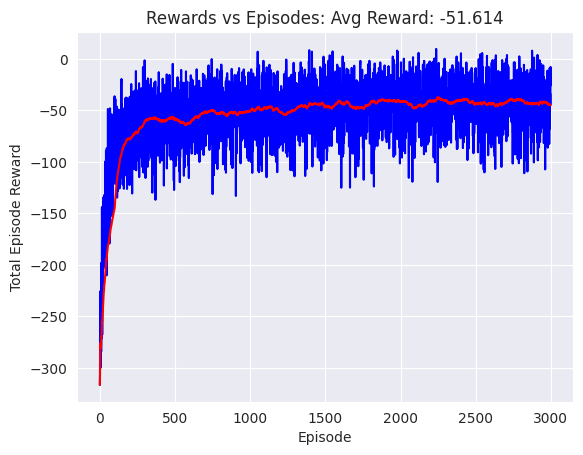

In [75]:
sns.set_style("darkgrid")
rewardlist = []

for i in range(10):
    Agent = SMDP(alpha = 0.5, epsilon = 0.1, gamma = 0.9)
    rew, _, _= Agent.trainer(verbose = True)
    rewardlist.append(rew)
    
rewardlist = np.array(rewardlist)
eps_rewards = np.mean(rewardlist, axis = 0)
avg100_reward = np.array([np.mean(eps_rewards[max(0,i-100):i]) for i in range(1,len(eps_rewards)+1)])

plt.xlabel('Episode')
plt.ylabel('Total Episode Reward')
plt.title('Rewards vs Episodes: Avg Reward: %.3f'%np.mean(eps_rewards))
plt.plot(np.arange(3000), eps_rewards, 'b')
plt.plot(np.arange(3000), avg100_reward, 'r', linewidth=1.5)
plt.savefig('./smdp/rewards.jpg', pad_inches = 0)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:11<00:00, 258.28it/s]


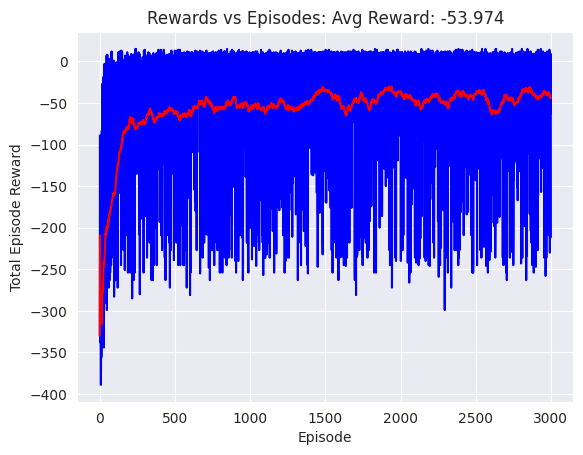

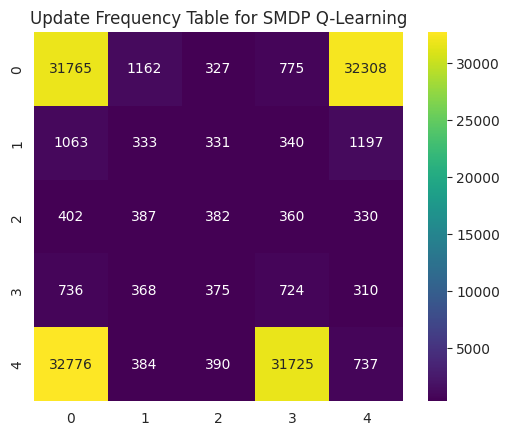

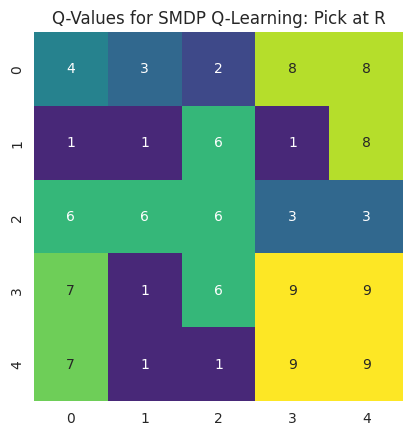

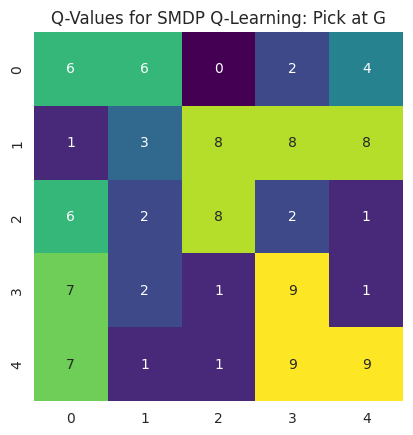

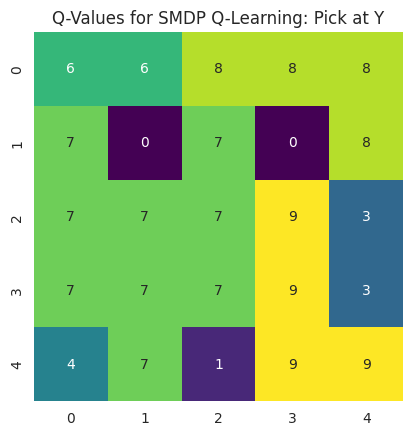

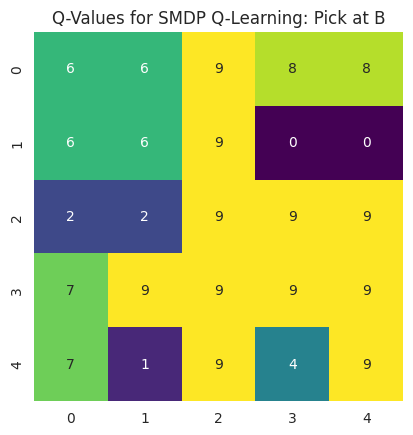

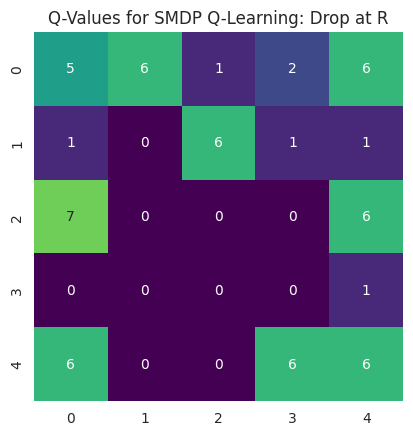

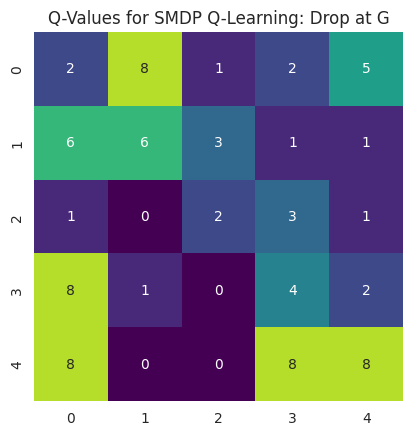

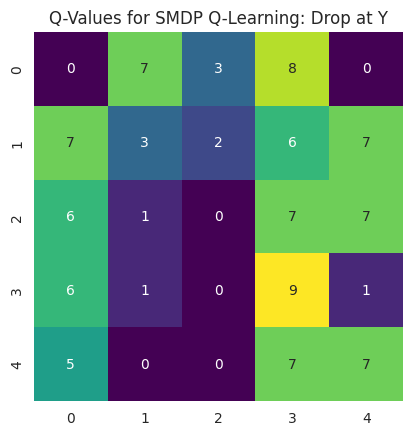

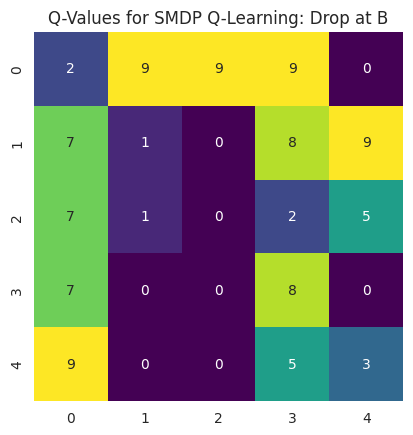

In [47]:
Agent0 = SMDP(alpha = 0.5, epsilon = 0.1, gamma = 0.9)
rewards0, q_vals0, update_freq0 = Agent0.trainer(verbose = True)
Agent0.plot_reward_curve(save = True)
Agent0.plot_update_freq(save = True)
Agent0.plot_q_values(save = True)

## Intra-option Q-Learning

The hyperparameters:

In [24]:
class IntraOption:
    """
    Intra_option_stuff
    """
    def __init__(self, gamma = 0.9, alpha = 0.1, epsilon = 0.1, opt_fns = opt_fns, gen_avl_options = gen_avl_options):
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.exp_name = 'a' + str(int(self.alpha*1000)) + '_e' + str(int(self.epsilon*1000)) + '_g' + str(int(self.gamma*100))
        self.q_values = np.zeros((500, 10))
        self.update_freq = np.zeros((500, 10))
        self.gen_avl_options = gen_avl_options
        self.opt_fns = opt_fns
        
        self.env = gym.make("Taxi-v3")
        
    def trainer(self, n_episodes = 3000, verbose = True):
        
        self.n_episodes = n_episodes
        self.eps_rewards = np.zeros(n_episodes)
        self.verbose = verbose
        
        # training over 3000 episodes
        for eps in (tqdm(range(n_episodes)) if verbose else range(n_episodes)):
    
            state = self.env.reset()    
            done = False
            eps_rew = 0

            while not done:

                available_actions = self.gen_avl_options(state, self.env)

                # Epsilon-greedy action selection
                action = egreedy_policy(self.q_values, state, available_actions, self.epsilon)

                # Primitive action selection
                if action < 6:

                    next_state, reward, done, _ = self.env.step(action)
                    self.q_values[state, action] += self.alpha*(reward + 
                                self.gamma*np.max(self.q_values[next_state, :]) - self.q_values[state, action])
                    self.update_freq[state, action] += 1

                    # We now check for options which produce the same primitive action
                    for j in range(4):

                        opt_fn = self.opt_fns[j]

                        opt_id = j + 6
                        opt_done, opt_action = opt_fn(state,self.env)

                        # update q_values for option if it produces the same primitive action
                        if opt_action == action:
                            self.q_values[state, opt_id] += self.alpha*(reward + 
                                self.gamma*np.max(self.q_values[next_state, :]) - self.q_values[state, opt_id])
                            self.update_freq[state, opt_id] += 1

                    # get the next state and update reward
                    state = next_state
                    eps_rew += reward


                # when an option is selected
                elif action >= 6: 
                    opt_done = False
                    start_state = state
                    
                    opt_fn = self.opt_fns[action-6]
                    time_steps = 0
                    
                    # while the option hasnt terminated
                    while (opt_done == False):

                        # Apply the option
                        opt_done, opt_action = opt_fn(state,self.env)
                        
                        # find reward and next state
                        next_state, reward, done, _ =self.env.step(opt_action)
                        start_state = state   
                        state = next_state

                        time_steps += 1
                        eps_rew += reward*(self.gamma**(time_steps - 1))

                        # If option is done, update and terminate
                        if opt_done:

                            self.q_values[start_state, action] +=self.alpha*(reward + 
                                    (self.gamma)*np.max(self.q_values[state, :]) - self.q_values[start_state, action])
                            self.update_freq[start_state, action] += 1

                            self.q_values[start_state, opt_action] +=self.alpha*(reward + 
                                    (self.gamma)*np.max(self.q_values[state, :]) - self.q_values[start_state, opt_action])
                            self.update_freq[start_state, opt_action] += 1

                            # for every other option which has the same primitive action we carry out q_value update
                            for j in range(4):

                                opt2_fn = self.opt_fns[j]

                                opt2_id = j + 6
                                opt2_done, opt2_action = opt_fn(state,self.env)

                                if opt_action == opt2_action:
                                    self.q_values[start_state, opt2_id] += self.alpha*(reward + 
                                            self.gamma*np.max(self.q_values[state, :]) - self.q_values[start_state, opt2_id])
                                    self.update_freq[state, opt2_id] += 1

                            break

                        # now carry out the normal update of q_values for option as well as the corresponding primitive action
                        self.q_values[start_state, action] +=self.alpha*(reward + 
                                    (self.gamma)*(self.q_values[state, action]) - self.q_values[start_state, action])
                        self.update_freq[start_state, action] += 1

                        self.q_values[start_state, opt_action] +=self.alpha*(reward + 
                                    (self.gamma)*(self.q_values[state, opt_action]) - self.q_values[start_state, opt_action])
                        self.update_freq[start_state, opt_action] += 1

                        # for normal update (non-terminating) check options which yield same primitive actions and carry out update
                        for j in range(4):

                            opt2_fn = self.opt_fns[j]

                            opt2_id = j + 6

                            opt2_done, opt2_action = opt_fn(state,self.env)

                            if opt_action == opt2_action:
                                self.q_values[start_state, opt2_id] += self.alpha*(reward +
                                            self.gamma*(self.q_values[state, opt2_id]) - self.q_values[start_state, opt2_id])
                                self.update_freq[state, opt2_id] += 1
                          
            # find total reward of episode
            self.eps_rewards[eps] = eps_rew
        return self.eps_rewards, self.q_values, self.update_freq
            
    def plot_reward_curve(self, save = False):
        sns.set_style("darkgrid")
        avg100_reward = np.array([np.mean(self.eps_rewards[max(0,i-100):i]) for i in range(1,len(self.eps_rewards)+1)])

        # print('Average Number of Episodes To Solve the Environment:', np.mean())

        plt.xlabel('Episode')
        plt.ylabel('Total Episode Reward')
        plt.title('Rewards vs Episodes: Avg Reward: %.3f'%np.mean(self.eps_rewards))
        plt.plot(np.arange(self.n_episodes), self.eps_rewards, 'b')
        plt.plot(np.arange(self.n_episodes), avg100_reward, 'r', linewidth=1.5)
        if save: 
            plt.savefig('./intraop/' + self.exp_name +'_rewards.jpg', pad_inches = 0)
        plt.show()
    
    def plot_update_freq(self, save = False):
        tot_updates = np.sum(self.update_freq, axis = 1)
        grid_updates = np.zeros((5,5))
        
        for state in range(500):
            row, col, src, dst = self.env.decode(state)
            grid_updates[row , col] += tot_updates[state]
            
        sns.heatmap(grid_updates, annot=True, fmt='g', square=True, cmap='viridis')
        plt.title('Update Frequency Table for Intra-Option Q-Learning')
        if save: 
            plt.savefig('./intraop/' + self.exp_name +'_updates.jpg', pad_inches = 0)
        plt.show()
    
    def plot_q_values(self, save = False):
        pickup_q_values = np.zeros((4,5,5,10))
        q_vals = np.zeros((2,4,5,5))
        for state in range(500):
            row, col, src, dest = self.env.decode(state)
            if src<4 and src!=dest:
                pickup_q_values[src][row][col] += self.q_values[state]
        
        for state in range(500):
            row, col, src, dest = self.env.decode(state)
            if src<4 and src!=dest:
                q_vals[0][src][row][col] = np.argmax(pickup_q_values[src][row][col])
            if src==4:
                q_vals[1][dest][row][col] = np.argmax(self.q_values[state])
        
        phase = ['Pick', 'Drop']
        pos = ['R', 'G', 'Y', 'B']
        for i in range(2):
            for j in range(4):
                sns.heatmap(q_vals[i][j], annot=True, square=True, cbar = False, cbar_kws={'ticks': range(10)}, vmin=0, vmax=9, cmap = 'viridis')
                plt.title('Q-Values for Intra-Option Q-Learning: {} at {}'.format(phase[i], pos[j]))
                if save: 
                    plt.savefig('./intraop/' + self.exp_name +'_q_vals_'+ phase[i] + '_'+ pos[j] + '.jpg', pad_inches = 0)
                plt.show()

## Hyperparameter Tuning 

We carry out hyperparameter tuning on the hyperparameters like $\alpha$ (learning rate) and $\epsilon$ the control parameter for the $\epsilon$-greedy action selection rule. 

This metric used to evaluate the performance of a combination of hyperparameters is the **average reward**. 

We test the following combinations of hyperparameters (total 20 configurations):

- $\alpha$: 0.5, 0.1, 0.05, 0.01
- $\epsilon$: 0.1, 0.05, 0.01, 0.005, 0.001

In [ ]:
with open('./logs/intraop_log1.txt', 'w') as f:

    sys.stdout = f 
    alphs = [0.5, 0.1, 0.05, 0.01]
    gams = [0.90]
    epsilons = [0.1, 0.05, 0.01, 0.005, 0.001]

    best_rew = - np.inf
    best_hparam = {'alpha':None, 'gamma':None, 'epsilon':None} 

    config = 1
    for a in alphs:
        for g in gams:
            for e in epsilons:
                print("Testing Configuration:", config)
                print('Hyperparameters: [alpha = {}, gamma = {}, epsilon = {}]'.format(a,g,e))
                Agent = IntraOption(alpha = a, epsilon = e, gamma = g)
                rewards, q_vals, update_freq = Agent.trainer(verbose = False)
                avg_reward = np.mean(rewards)
                print('Average Reward:', avg_reward)
                print('***************************************************************************\n')

                if avg_reward>best_rew:
                    best_rew = avg_reward
                    best_hparam['alpha'] = a
                    best_hparam['gamma'] = g
                    best_hparam['epsilon'] = e
                    
                config += 1

    print('\nBest Reward:', best_rew)
    print('Best Hyperparameters:', best_hparam)

## Optimal Setup

We now calculate average of the reward generated across 10 runs.

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 457.10it/s]


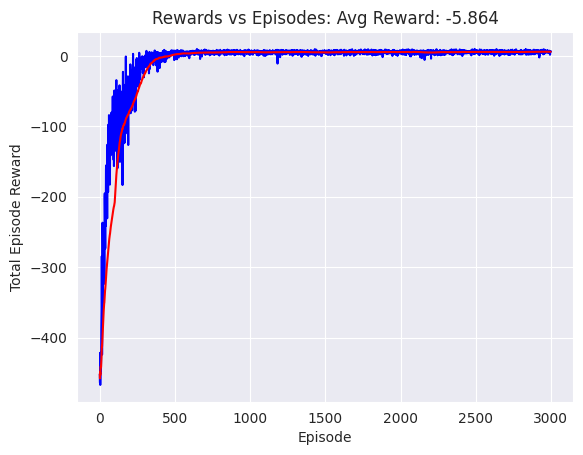

In [36]:
sns.set_style("darkgrid")
rewardlist = []

for i in range(10):
    Agent = IntraOption(alpha = 0.5, epsilon = 0.001, gamma = 0.9)
    rew, _, _= Agent.trainer(verbose = True)
    rewardlist.append(rew)
    
rewardlist = np.array(rewardlist)
eps_rewards = np.mean(rewardlist, axis = 0)
avg100_reward = np.array([np.mean(eps_rewards[max(0,i-100):i]) for i in range(1,len(eps_rewards)+1)])

plt.xlabel('Episode')
plt.ylabel('Total Episode Reward')
plt.title('Rewards vs Episodes: Avg Reward: %.3f'%np.mean(eps_rewards))
plt.plot(np.arange(3000), eps_rewards, 'b')
plt.plot(np.arange(3000), avg100_reward, 'r', linewidth=1.5)
plt.savefig('./intraop/rewards.jpg', pad_inches = 0)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 450.10it/s]


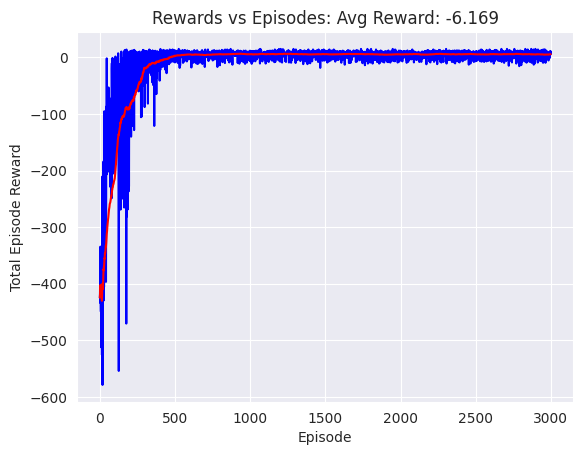

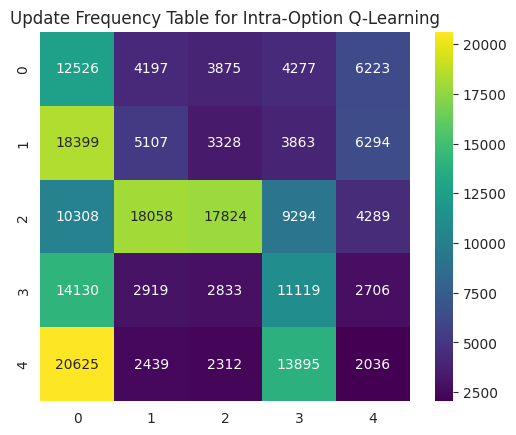

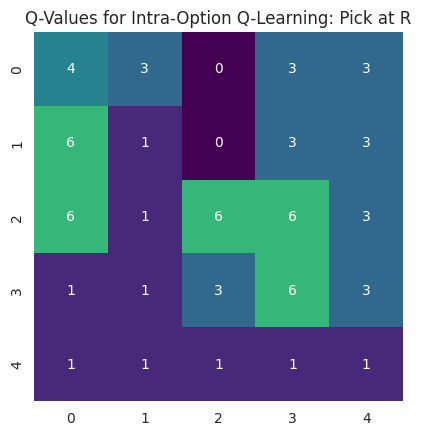

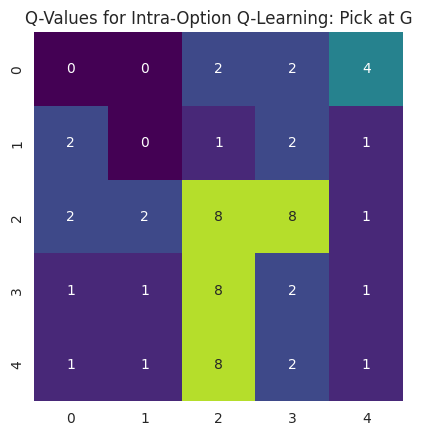

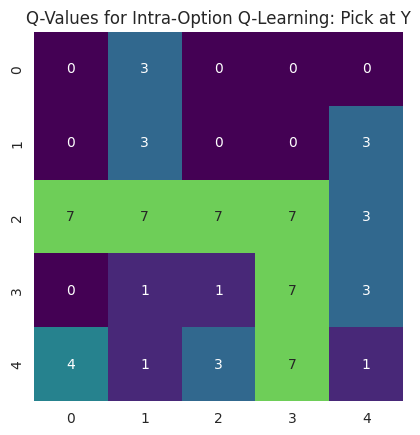

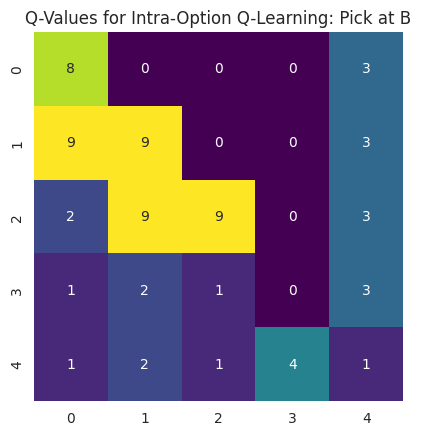

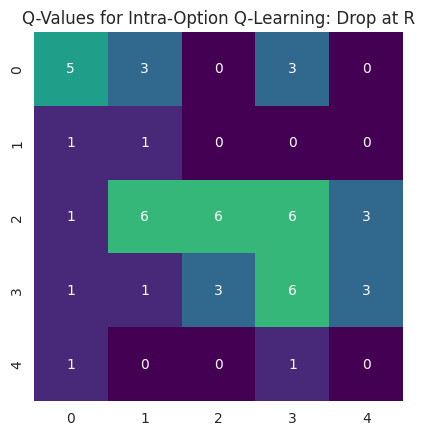

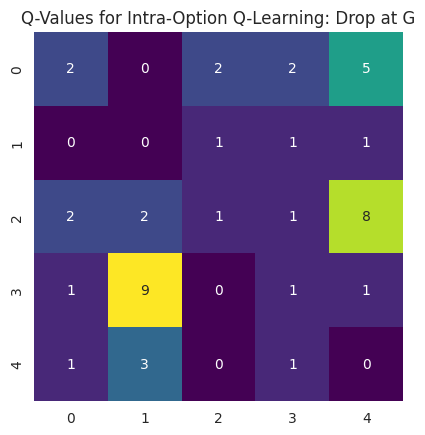

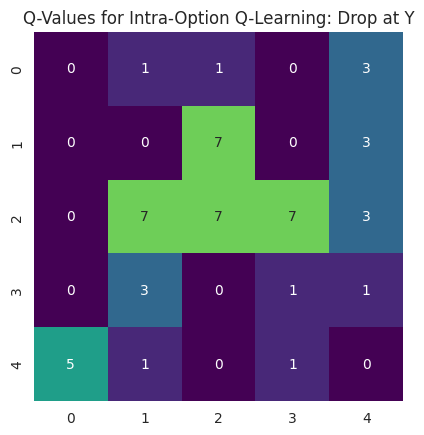

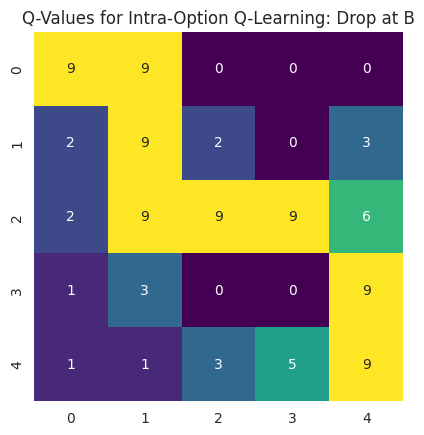

In [39]:
Agent1 = IntraOption(alpha = 0.5, epsilon = 0.001, gamma = 0.9)
rewards1, q_vals1, update_freq1 = Agent1.trainer(verbose = True)
Agent1.plot_reward_curve(save = True)
Agent1.plot_update_freq(save = True)
Agent1.plot_q_values(save = True)

## SMDP vs IntraOption

We first compare the rewards obtained in case of both SMDP and Intra-Option Q-Learning. The plots for the rewards are taken with a moving average across a window of 10 episodes. This smoothens the irregularities of the plot enough to be able to make good observations about the general trends.

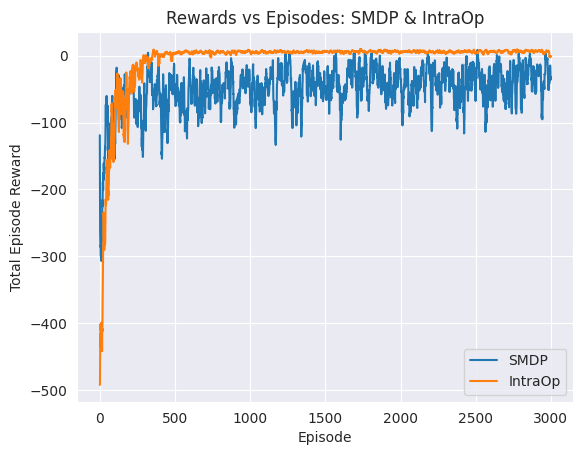

In [35]:
sns.set_style("darkgrid")
avg10_reward0 = np.array([np.mean(rewards0[max(0,i-10):i]) for i in range(1,len(rewards0)+1)])
avg10_reward1 = np.array([np.mean(rewards1[max(0,i-10):i]) for i in range(1,len(rewards1)+1)])

plt.xlabel('Episode')
plt.ylabel('Total Episode Reward')
plt.title('Rewards vs Episodes: SMDP & IntraOp')
plt.plot(np.arange(len(rewards0)), avg10_reward0)
plt.plot(np.arange(len(rewards1)), avg10_reward1)
plt.legend(['SMDP', 'IntraOp'])
plt.savefig('./gen_imgs/smdp_v_intraop_rewards.jpg', pad_inches = 0)
plt.show()

The update frequency tables for the two cases can be given with a common colorbar to fully appreciate the differences in the updates being made.

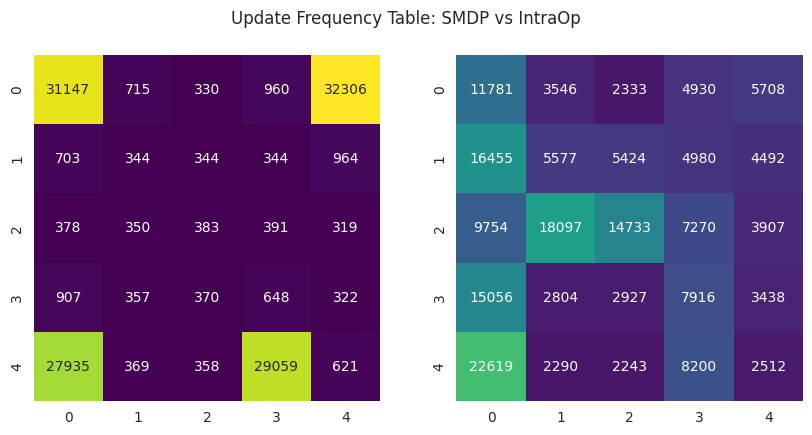

In [65]:
tot_updates0 = np.sum(update_freq0, axis = 1)
tot_updates1 = np.sum(update_freq1, axis = 1)
grid_updates0 = np.zeros((5,5))
grid_updates1 = np.zeros((5,5))

for state in range(500):
    row, col, src, dst = env.decode(state)
    grid_updates0[row , col] += tot_updates0[state]
    grid_updates1[row , col] += tot_updates1[state]
    
vmin = min(np.min(grid_updates0), np.min(grid_updates1))
vmax = max(np.max(grid_updates0), np.max(grid_updates1))

figure, axs = plt.subplots(1, 2)
figure.suptitle('Update Frequency Table: SMDP vs IntraOp')

sns.heatmap(grid_updates0, annot=True, fmt='g', square=True, cmap='viridis', cbar=False, ax=axs[0], vmin=vmin, vmax=vmax)
sns.heatmap(grid_updates1, annot=True, fmt='g', square=True, cmap='viridis', cbar=False, ax=axs[1], vmin=vmin, vmax=vmax)

figure.set_figwidth(10)
figure.set_figheight(4.5)
plt.savefig('./gen_imgs/smdp_v_intraop_updates.jpg', pad_inches = 0)

plt.show()

## Alternate Option Definitions

We now define the alternate set of actions, that aim to send the agent to a certain fixed direction based on the action selected. They are defined below.

In [25]:
def keep_south(state, env):
    # Decode the state
    row, col, _, _ = list(env.decode(state))

    # Default values for action and termination condition
    opt_done = False
    opt_action = 0

    # Target reached
    if (row == 4):
        opt_done = True
        return opt_done, opt_action

    opt_action = 0
    return opt_done, opt_action

In [26]:
def keep_north(state, env):

    # Decode the state
    row, col, _, _ = list(env.decode(state))

    # Default values for action and termination condition
    opt_done = False
    opt_action = 0

    # Target reached
    if (row == 0):
        opt_done = True
        return opt_done, opt_action

    opt_action = 1
    return opt_done, opt_action

In [27]:
def keep_east(state, env):

    # Decode the state
    row, col, _, _ = list(env.decode(state))

    # Default values for action and termination condition
    opt_done = False
    opt_action = 0

    # Target reached
    if ((col == 4) or ((row == 0 and col == 1) or (row == 1 and col == 1))
            or ((row == 3 and col == 0) or (row == 3 and col == 2) or (row == 4 and col == 0) 
            or (row == 4 and col == 2))):
        opt_done = True
        return opt_done, opt_action

    opt_action = 2
    return opt_done, opt_action

In [28]:
def keep_west(state, env):

    # Decode the state
    row, col, _, _ = list(env.decode(state))

    # Default values for action and termination condition
    opt_done = False
    opt_action = 0

    # Target reached
    if ((col == 0) or ((row == 0 and col == 2) or (row == 1 and col == 2))
            or ((row == 3 and col == 1) or (row == 3 and col == 3) 
            or (row == 4 and col == 1) or (row == 4 and col == 3))):
        opt_done = True
        return opt_done, opt_action

    opt_action = 3
    return opt_done, opt_action

We now consider the new code to generate the list of available options:

In [29]:
def gen_avl_options_new(state, env):

    row, col, _, _ = list(env.decode(state))
    avl_actions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    if (row == 4):
        avl_actions.pop(6)
        return avl_actions

    if (row == 0):
        avl_actions.pop(7)
        return avl_actions

    if ((col == 4) or ((row == 0 and col == 1) or (row == 1 and col == 1)) or ((row == 3 and col == 0) or (row == 3 and col == 2) or (row == 4 and col == 0) or (row == 4 and col == 2))):
        avl_actions.pop(8)
        return avl_actions

    if ((col == 0) or ((row == 0 and col == 2) or (row == 1 and col == 2)) or ((row == 3 and col == 1) or (row == 3 and col == 3) or (row == 4 and col == 1) or (row == 4 and col == 3))):
        avl_actions.pop(9)
        return avl_actions

    return avl_actions

We also define the new set of opt_functions

In [30]:
opt_fns_new = [keep_south, keep_north, keep_east, keep_west]

## Intra-Option with Alternate Options

In [ ]:
with open('./logs/intraop_log2.txt', 'w') as f:

    sys.stdout = f 
    alphs = [0.5, 0.1, 0.05, 0.01]
    gams = [0.90]
    epsilons = [0.1, 0.01, 0.001]

    best_rew = - np.inf
    best_hparam = {'alpha':None, 'gamma':None, 'epsilon':None} 

    config = 1
    for a in alphs:
        for g in gams:
            for e in epsilons:
                print("Testing Configuration:", config)
                print('Hyperparameters: [alpha = {}, gamma = {}, epsilon = {}]'.format(a,g,e))
                Agent = IntraOption(alpha = a, epsilon = e, gamma = g, opt_fns = opt_fns_new, gen_avl_options = gen_avl_options_new)
                rewards, q_vals, update_freq = Agent.trainer(verbose = False)
                avg_reward = np.mean(rewards)
                print('Average Reward:', avg_reward)
                print('***************************************************************************\n')

                if avg_reward>best_rew:
                    best_rew = avg_reward
                    best_hparam['alpha'] = a
                    best_hparam['gamma'] = g
                    best_hparam['epsilon'] = e

                config += 1

    print('\nBest Reward:', best_rew)
    print('Best Hyperparameters:', best_hparam)

We now take the best combination of hyperparameters and calculate the average reward across 10 runs:

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 477.48it/s]


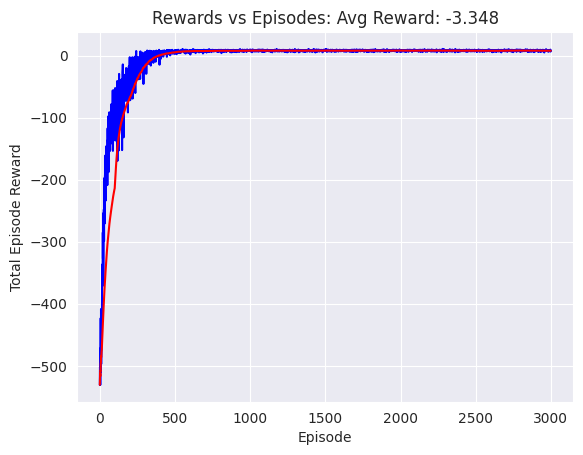

In [37]:
sns.set_style("darkgrid")
rewardlist = []

for i in range(10):
    Agent = IntraOption(alpha = 0.5, epsilon = 0.001, gamma = 0.9, opt_fns = opt_fns_new, gen_avl_options = gen_avl_options_new)
    rew, _, _= Agent.trainer(verbose = True)
    rewardlist.append(rew)
    
rewardlist = np.array(rewardlist)
eps_rewards = np.mean(rewardlist, axis = 0)
avg100_reward = np.array([np.mean(eps_rewards[max(0,i-100):i]) for i in range(1,len(eps_rewards)+1)])

plt.xlabel('Episode')
plt.ylabel('Total Episode Reward')
plt.title('Rewards vs Episodes: Avg Reward: %.3f'%np.mean(eps_rewards))
plt.plot(np.arange(3000), eps_rewards, 'b')
plt.plot(np.arange(3000), avg100_reward, 'r', linewidth=1.5)
plt.savefig('./intraop/rewards_new.jpg', pad_inches = 0)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 475.76it/s]


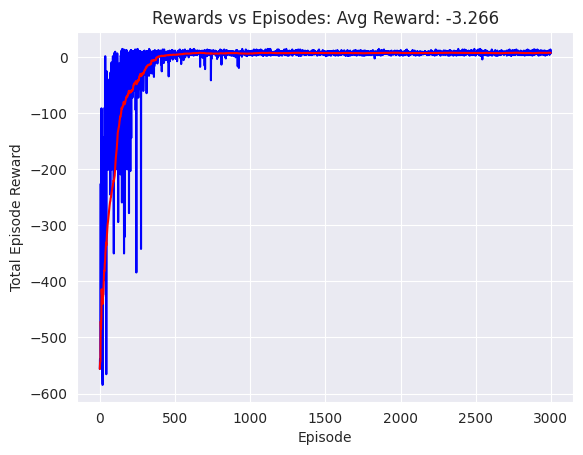

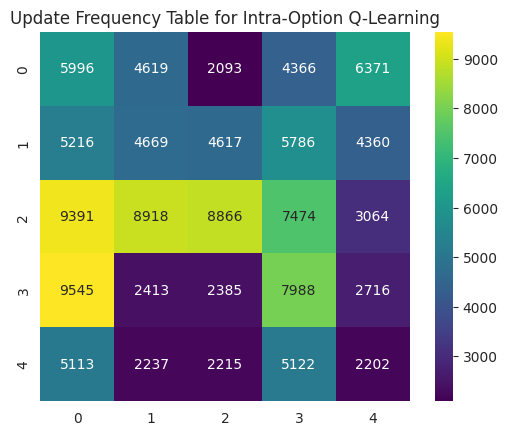

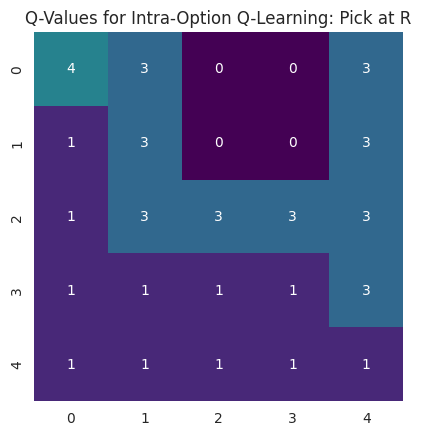

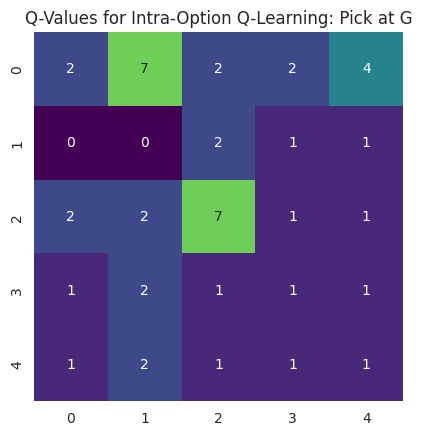

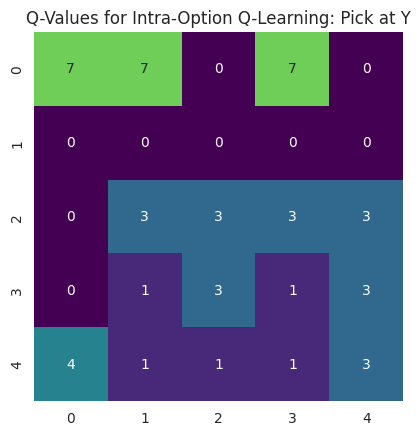

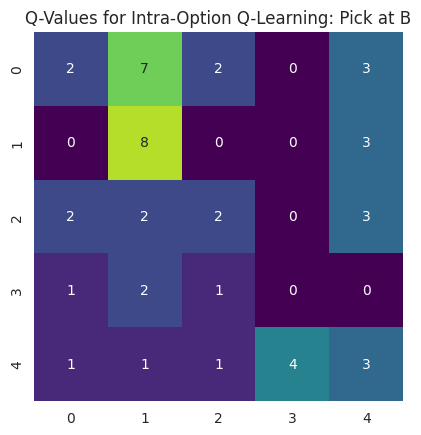

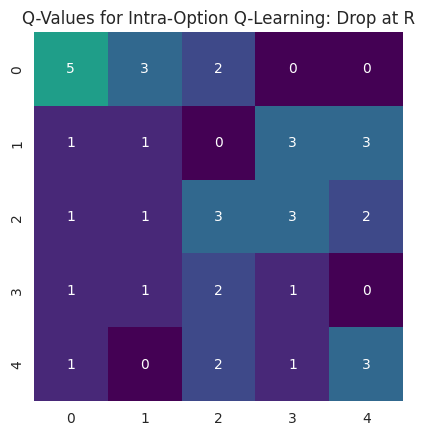

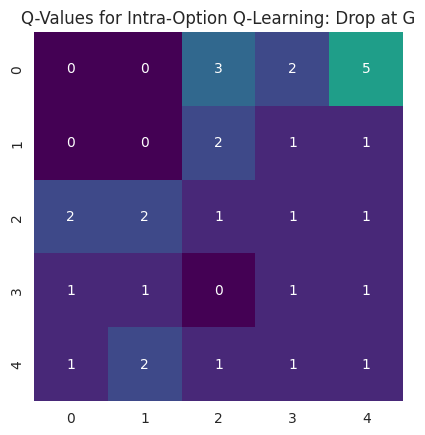

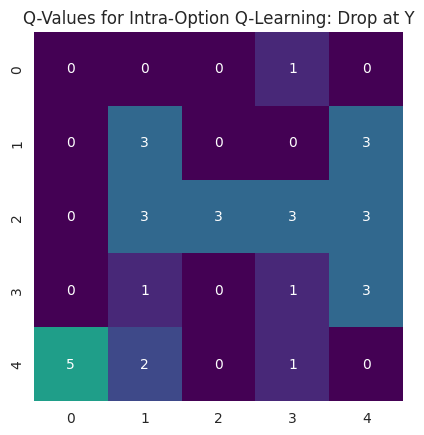

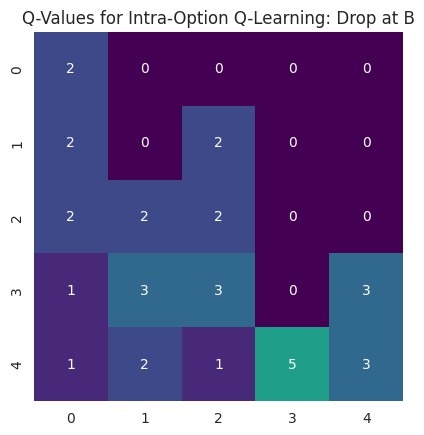

In [40]:
Agent11 = IntraOption(alpha = 0.5, epsilon = 0.001, gamma = 0.9, opt_fns=opt_fns_new, gen_avl_options=gen_avl_options_new)
rewards11, q_vals11, update_freq11 = Agent11.trainer(verbose = True)
Agent11.plot_reward_curve(save = False)
Agent11.plot_update_freq(save = False)
Agent11.plot_q_values(save = False)

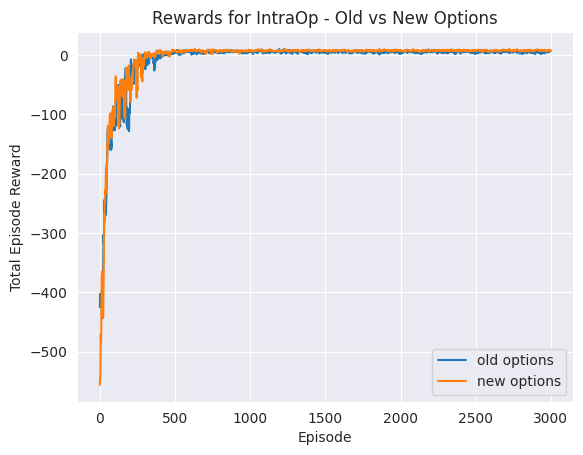

In [54]:
sns.set_style("darkgrid")
avg10_reward1 = np.array([np.mean(rewards1[max(0,i-10):i]) for i in range(1,len(rewards1)+1)])
avg10_reward11 = np.array([np.mean(rewards11[max(0,i-10):i]) for i in range(1,len(rewards11)+1)])

plt.xlabel('Episode')
plt.ylabel('Total Episode Reward')
plt.title('Rewards for IntraOp - Old vs New Options')
plt.plot(np.arange(len(rewards1)), avg10_reward1)
plt.plot(np.arange(len(rewards11)), avg10_reward11)
plt.legend(['old options', 'new options'])
plt.savefig('./intraop/old_v_new_rewards.jpg', pad_inches = 0)
plt.show()

## SMDP with Alternate Options

In [ ]:
with open('./logs/smdp_log2.txt', 'w') as f:

    sys.stdout = f 
    alphs = [0.5, 0.1, 0.05, 0.01]
    gams = [0.90]
    epsilons = [0.1]

    best_rew = - np.inf
    best_hparam = {'alpha':None, 'gamma':None, 'epsilon':None} 

    config = 1
    for a in alphs:
        for g in gams:
            for e in epsilons:
                print("Testing Configuration:", config)
                print('Hyperparameters: [alpha = {}, gamma = {}, epsilon = {}]'.format(a,g,e))
                Agent = SMDP(alpha = a, epsilon = e, gamma = g, opt_fns = opt_fns_new, gen_avl_options = gen_avl_options_new)
                rewards, q_vals, update_freq = Agent.trainer(verbose = False)
                avg_reward = np.mean(rewards)
                print('Average Reward:', avg_reward)
                print('***************************************************************************\n')

                if avg_reward>best_rew:
                    best_rew = avg_reward
                    best_hparam['alpha'] = a
                    best_hparam['gamma'] = g
                    best_hparam['epsilon'] = e

                config += 1

    print('\nBest Reward:', best_rew)
    print('Best Hyperparameters:', best_hparam)

We now plot average rewards across 5 runs

100%|███████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:43<00:00, 29.05it/s]


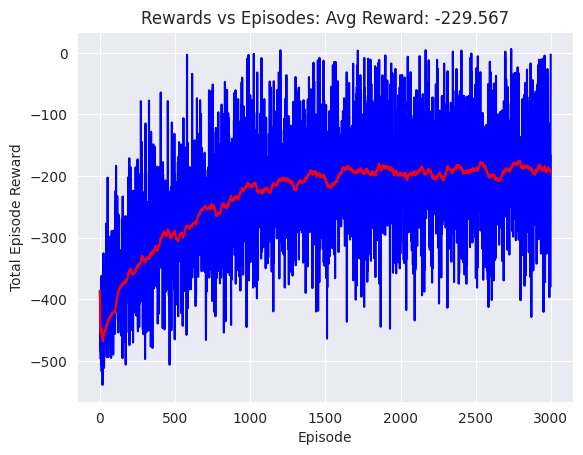

In [45]:
sns.set_style("darkgrid")
rewardlist = []

for i in range(5):
    Agent = SMDP(alpha = 0.5, epsilon = 0.1, gamma = 0.9, opt_fns = opt_fns_new, gen_avl_options = gen_avl_options_new)
    rew, _, _= Agent.trainer(verbose = True)
    rewardlist.append(rew)
    
rewardlist = np.array(rewardlist)
eps_rewards = np.mean(rewardlist, axis = 0)
avg100_reward = np.array([np.mean(eps_rewards[max(0,i-100):i]) for i in range(1,len(eps_rewards)+1)])

plt.xlabel('Episode')
plt.ylabel('Total Episode Reward')
plt.title('Rewards vs Episodes: Avg Reward: %.3f'%np.mean(eps_rewards))
plt.plot(np.arange(3000), eps_rewards, 'b')
plt.plot(np.arange(3000), avg100_reward, 'r', linewidth=1.5)
plt.savefig('./smdp/rewards_new.jpg', pad_inches = 0)
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:01<00:00, 48.71it/s]


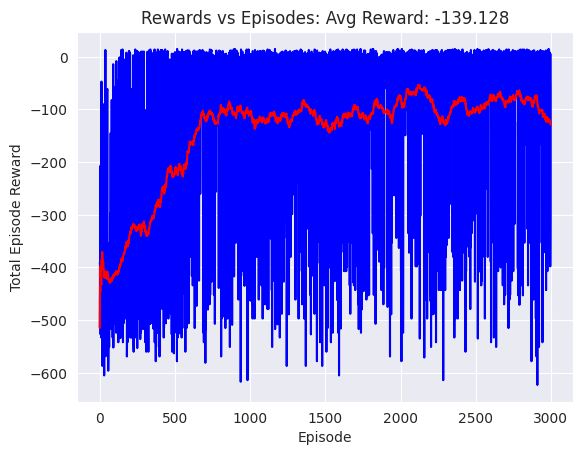

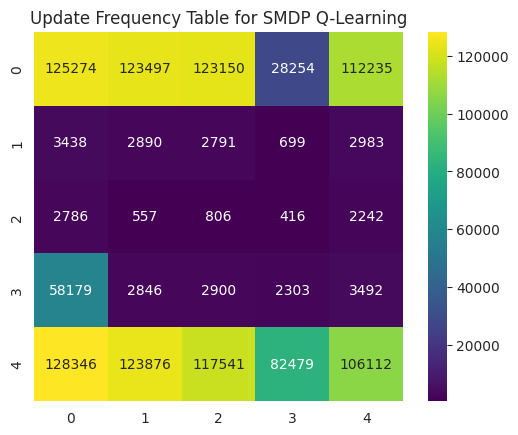

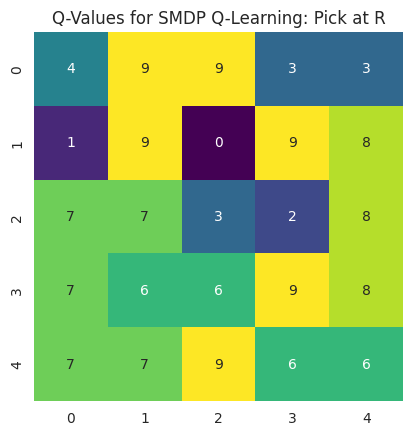

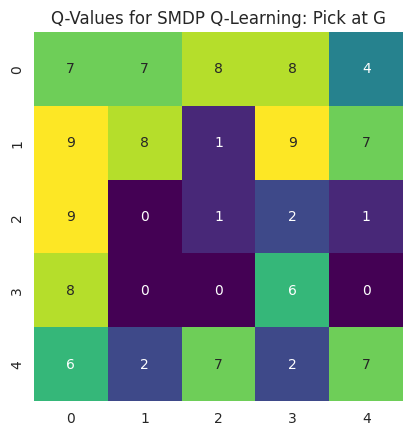

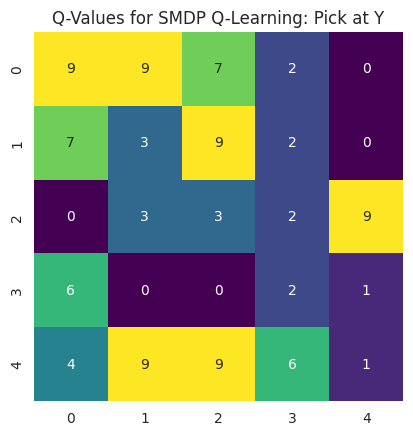

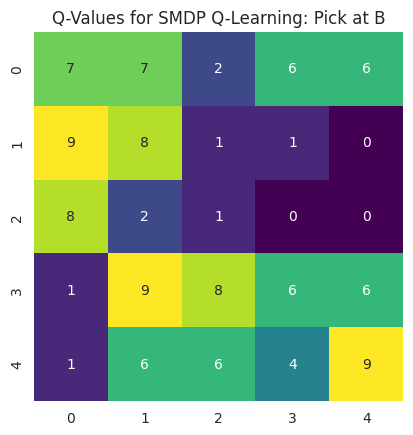

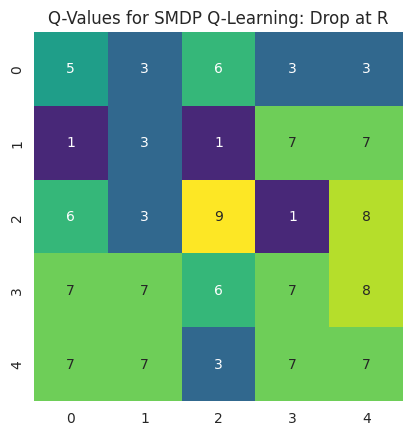

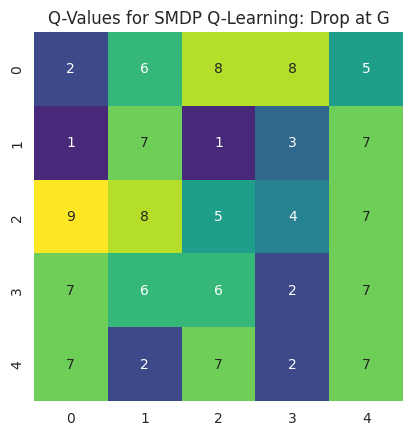

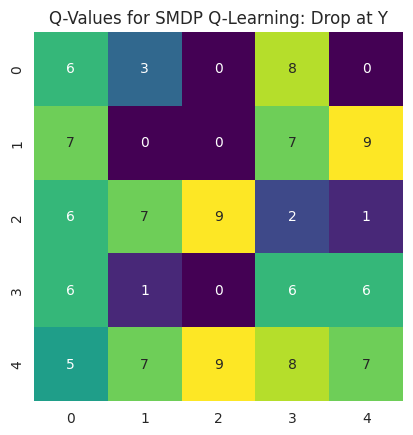

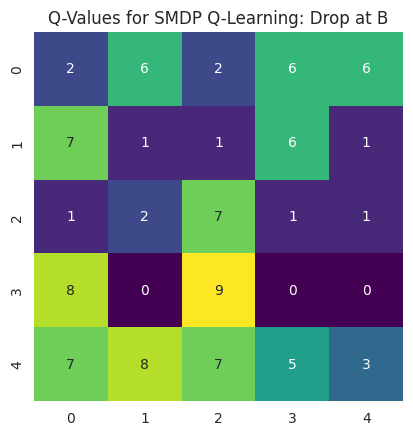

In [51]:
Agent01 = SMDP(alpha = 0.5, epsilon = 0.1, gamma = 0.9, opt_fns=opt_fns_new, gen_avl_options=gen_avl_options_new)
rewards01, q_vals01, update_freq01 = Agent01.trainer(verbose = True)
Agent01.plot_reward_curve(save = False)
Agent01.plot_update_freq(save = False)
Agent01.plot_q_values(save = False)

We now compare old and new options for SMDP Q-Learning:

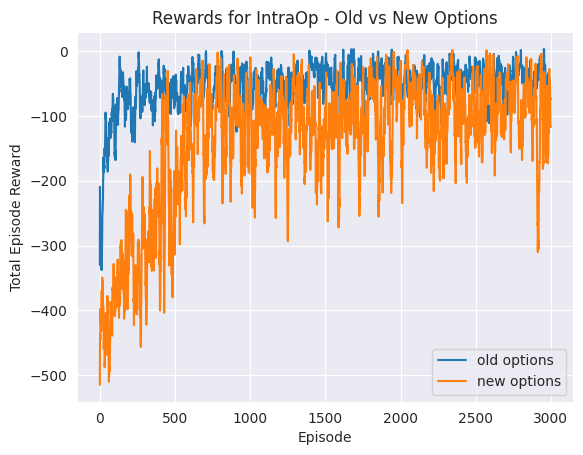

In [53]:
sns.set_style("darkgrid")
avg10_reward0 = np.array([np.mean(rewards0[max(0,i-10):i]) for i in range(1,len(rewards0)+1)])
avg10_reward01 = np.array([np.mean(rewards01[max(0,i-10):i]) for i in range(1,len(rewards01)+1)])

plt.xlabel('Episode')
plt.ylabel('Total Episode Reward')
plt.title('Rewards for IntraOp - Old vs New Options')
plt.plot(np.arange(len(rewards0)), avg10_reward0)
plt.plot(np.arange(len(rewards01)), avg10_reward01)
plt.legend(['old options', 'new options'])
plt.savefig('./smdp/old_v_new_rewards.jpg', pad_inches = 0)
plt.show()